# Podsumowanie
W tym notebook'u mamy przeprowadzony transfer nauczonych wag z pretrainingu sieci. Wagi wszystkich warstw enkodera poza ostatnim blokiem są zamrożone. Udało nam się uzyskać delikatnie lepszy wynik, co ukazane jest na końcu notebook'a.

# Transfer Learning

In [1]:
from keras.models import *
from custom_layers import BatchNormalization, Softmax4D
from keras.layers import Input, UpSampling2D, MaxPooling2D, Convolution2D, Activation, ZeroPadding2D

i = Input((None, None, 3))

#encoding layers
o = (ZeroPadding2D((1, 1)))(i)
o = (Convolution2D(64, (3, 3), padding='valid'))(o)
o = (BatchNormalization())(o)
o = (MaxPooling2D(pool_size=(2, 2)))(o)

o = (ZeroPadding2D((1, 1)))(o)
o = (Convolution2D(128, (3, 3), padding='valid'))(o)
o = (Activation('relu'))(o)
o = (BatchNormalization())(o)
o = (MaxPooling2D(pool_size=(2, 2)))(o)

o = (ZeroPadding2D((1, 1)))(o)
o = (Convolution2D(256, (3, 3), padding='valid'))(o)
o = (Activation('relu'))(o)
o = (BatchNormalization())(o)
o = (MaxPooling2D(pool_size=(2, 2)))(o)

o = (ZeroPadding2D((1, 1)))(o)
o = (Convolution2D(512, (3, 3), padding='valid'))(o)
o = (Activation('relu'))(o)
o1 = (BatchNormalization())(o)

encoder = Model(inputs=i, outputs=o1)

In [2]:
saved_weights_dir = 'model-57eeb59c-df0b-4224-88de-af7b25904abd/'
encoder.load_weights(saved_weights_dir + 'encoder.hdf5')

In [3]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1792      
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 64)    256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, None, None, 64)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 128)   73856 

In [4]:
import custom_metrics as M
from keras.optimizers import Adam

k = (ZeroPadding2D((1, 1)))(encoder.output)
k = (Convolution2D(512, (3, 3), padding='valid'))(k)
k = (BatchNormalization())(k)

k = (UpSampling2D((2, 2)))(k)
k = (ZeroPadding2D((1, 1)))(k)
k = (Convolution2D(256, (3, 3), padding='valid'))(k)
k = (BatchNormalization())(k)

k = (UpSampling2D((2, 2)))(k)
k = (ZeroPadding2D((1, 1)))(k)
k = (Convolution2D(128, (3, 3), padding='valid'))(k)
k = (BatchNormalization())(k)

k = (UpSampling2D((2, 2)))(k)
k = (ZeroPadding2D((1, 1)))(k)
k = (Convolution2D(64, (3, 3), padding='valid'))(k)
k = (BatchNormalization())(k)

k = (Convolution2D(2, (1,1), padding='valid'))(k)
k1 = (Softmax4D())(k)
segnet = Model(inputs=encoder.input, outputs=k1)

class_weights = [1516.576, 0.1]
unsuper_weight = 0.1

loss = M.loss(weights=class_weights, unsuper_weight=unsuper_weight, unsuper_channel=-1)
wcce = M.wcceOA(weights=class_weights)
uentr = M.entrONA(unsuper_channel=-1)
wacc = M.waccOA(weights=class_weights)

segnet.compile(optimizer=Adam(0.01), loss=loss, metrics=[wcce, uentr, wacc])

In [5]:
segnet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1792      
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 64)    256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, None, None, 64)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 128)   7385

In [6]:
len(segnet.trainable_weights)

34

In [7]:
train = False
for layer in segnet.layers:
    #warstwa od której zaczyna się ostatni blok
    if layer.name.startswith('zero_padding2d_3'):
        train = True
    layer.trainable = train

len(segnet.trainable_weights)

22

In [8]:
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import LungNet as LN
import uuid
import os


modeldir = 'model-'+str(uuid.uuid4())
print(modeldir)
if not os.path.exists(modeldir):
    os.makedirs(modeldir)
open(modeldir+'/architecture.json', 'w').write(segnet.to_json())
plot_model(segnet, to_file=modeldir+'/model.png', show_shapes=True)

train_gen = LN.sample_generator('lidc-train.npz')
val_gen = LN.sample_generator('lidc-val.npz', augment=False)

checkpoints = ModelCheckpoint(modeldir+'/weights.{epoch:02d}-{val_waccOA:.2f}.hdf5', 
                              monitor='val_waccOA', verbose=1, mode='max',
                              save_best_only=True)
earlystopping = EarlyStopping(monitor='val_waccOA', min_delta=0.001, patience=40, 
                              verbose=1, mode='max')
logger = CSVLogger(modeldir+'/training.log')

# fit model
segnet.fit_generator(train_gen, 800, 1000, validation_data=val_gen, validation_steps=200,
                    callbacks=[checkpoints, earlystopping, logger])

model-41b50e62-3c68-4daf-b520-a306a21301c3


C:\Users\PC-Komputer\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
800/800 [==============================] - 180s 202ms/step - loss: 0.4106 - wcceOA: 0.4175 - entrONA: 0.3486 - waccOA: 0.8491 - val_loss: 0.4334 - val_wcceOA: 0.4360 - val_entrONA: 0.4100 - val_waccOA: 0.8545

Epoch 00001: val_waccOA improved from -inf to 0.85450, saving model to model-41b50e62-3c68-4daf-b520-a306a21301c3\weights.01-0.85.hdf5
Epoch 2/1000
800/800 [==============================] - 140s 175ms/step - loss: 0.3209 - wcceOA: 0.3185 - entrONA: 0.3430 - waccOA: 0.8788 - val_loss: 0.3024 - val_wcceOA: 0.3002 - val_entrONA: 0.3218 - val_waccOA: 0.8861

Epoch 00002: val_waccOA improved from 0.85450 to 0.88608, saving model to model-41b50e62-3c68-4daf-b520-a306a21301c3\weights.02-0.89.hdf5
Epoch 3/1000
800/800 [==============================] - 140s 176ms/step - loss: 0.2477 - wcceOA: 0.2441 - entrONA: 0.2800 - waccOA: 0.9024 - val_loss: 0.2403 - val_wcceOA: 0.2365 - val_entrONA: 0.2744 - val_waccOA: 0.9142

Epoch 00003: val_waccOA improved from 0.88608 to 0.91423, 

# Podsumowanie wyników
Jak widać nam poniższym wykresie udało nam się uzyskać delikatnie lepszy wynik. W tabelce mamy dokładne liczbowe porównanie najlepszych wyników osiągniętych na zbiorze walidacyjnym.

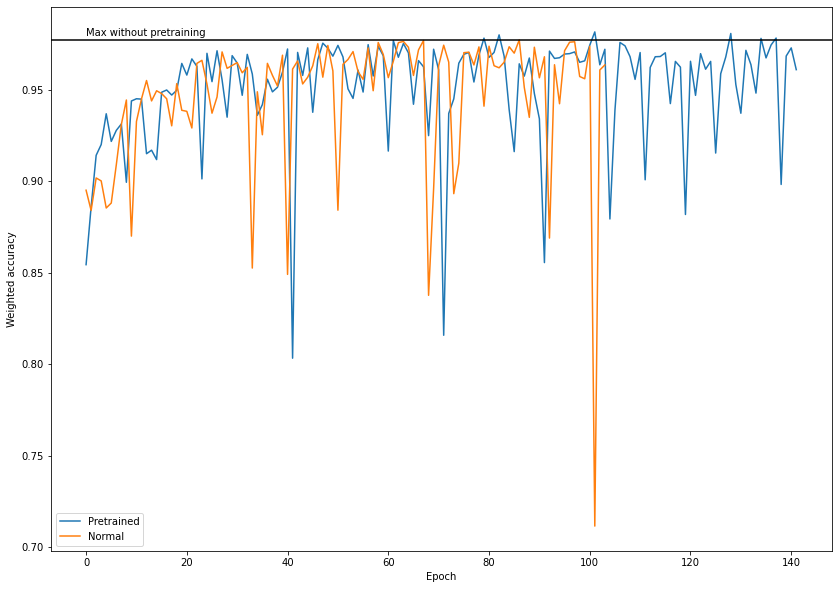

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

pretrained_data = pd.read_csv('model-41b50e62-3c68-4daf-b520-a306a21301c3/training.log')
normal_data = pd.read_csv('modeleAF/model-e6dc8464-7322-4237-b669-95e4ad5819cb/training.log')

plt.figure(figsize=(14,10))
plt.plot(pretrained_data.epoch, pretrained_data.val_waccOA, label = 'Pretrained')
plt.plot(normal_data.epoch, normal_data.val_waccOA, label = 'Normal')
plt.axhline(normal_data.val_waccOA.max(), color = 'black')
plt.text(x=0, y=normal_data.val_waccOA.max()+0.002, s='Max without pretraining')
plt.xlabel('Epoch')
plt.ylabel('Weighted accuracy')
plt.legend()
plt.show()

In [11]:
pd.DataFrame([pretrained_data.val_waccOA.max(), normal_data.val_waccOA.max()],
            index=['Max pretrained', 'Max normal'], columns=['Weighted accuracy'])

,Weighted accuracy
Max pretrained,0.981655
Max normal,0.977278
